# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [ ]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [ ]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [ ]:
import numpy as np

np.__version__

In [4]:
import pandas as pd

pd.__version__

'1.2.3'

In [5]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [7]:
import seaborn as sns

sns.__version__

'0.11.1'

## Загрузка данных

[Источник (Churn Modelling)](https://www.kaggle.com/shrutimechlearn/churn-modelling)

In [8]:
df = pd.read_csv("./../../data/Churn_Modelling.csv", index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


## Разделение данных на `X` и `y`

In [10]:
# колонка, которая не несет полезной информации
# если добавить, то может испортить качество, так как
# номер пользователя объективно не должен влиять на результ
del df['CustomerId']

In [11]:
target_column_name = 'Exited'

In [12]:
from sklearn.model_selection import train_test_split

y = df[target_column_name].copy()
X = df.loc[:, df.columns != target_column_name].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Этап 1 ("Straightforward")

### Анализ и обработка пропущенных значений

In [13]:
df.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Преобразование типов и очистка

In [14]:
for col_name in X.select_dtypes(include='object'):
    print(f'{col_name} : {df[col_name].nunique()}')
    print('-' * 20)

Surname : 2932
--------------------
Geography : 3
--------------------
Gender : 2
--------------------


In [15]:
X['Surname'] = X.Surname.astype('string')
X['Geography'] = X.Geography.astype('string')
X['Gender'] = X.Gender.astype('category')

In [16]:
for col_name in X.select_dtypes(include=int):
    nunique = X[col_name].nunique()
    
    print(f'{col_name} : {nunique}')
    if nunique < 40:
        display(X[col_name].value_counts())
        if nunique == 2 and set(X[col_name].unique()) == {0, 1}:
            X[col_name] = X[col_name].astype('boolean')
            print('->boolean')
    print('-' * 20)

CreditScore : 460
--------------------
Age : 70
--------------------
Tenure : 11


2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

--------------------
NumOfProducts : 4


1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

--------------------
HasCrCard : 2


1    7055
0    2945
Name: HasCrCard, dtype: int64

->boolean
--------------------
IsActiveMember : 2


1    5151
0    4849
Name: IsActiveMember, dtype: int64

->boolean
--------------------


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Surname          10000 non-null  string  
 1   CreditScore      10000 non-null  int64   
 2   Geography        10000 non-null  string  
 3   Gender           10000 non-null  category
 4   Age              10000 non-null  int64   
 5   Tenure           10000 non-null  int64   
 6   Balance          10000 non-null  float64 
 7   NumOfProducts    10000 non-null  int64   
 8   HasCrCard        10000 non-null  boolean 
 9   IsActiveMember   10000 non-null  boolean 
 10  EstimatedSalary  10000 non-null  float64 
dtypes: boolean(2), category(1), float64(2), int64(4), string(2)
memory usage: 752.1 KB


### Анализ баланса целевой переменной (`y`)

In [18]:
def plot_cat_count_s(cs: pd.Series):
    """
    Функция для рисования countplot для Series
    """
    
    # создать график (сетка 1x1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    # создать countplot
    g = sns.countplot(x=cs, 
                      ax=ax)

    # повернуть подписи категорий на 45 градусов
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')

    # отключить подпись оси x и y
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    # наименование графика справа цветом графика
    ax.set_title(cs.name, 
                 loc='right', 
                 fontsize=15)

    # включить сетку на графике
    ax.grid()

    # сколько всего записей для всех категорий в колонке
    total = len(cs)
    
    print(f"{total} ({cs.name})")

    # для каждого столбца на графике сверху добавить процент
    for p in ax.patches:
        # вычислить процент, который соответствует текущему столбцу
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)

        # начало (слева) столбца на графике по оси x
        x_pos = p.get_x()

        # верх столбца на графике по оси x
        y_pos = p.get_y() + p.get_height()

        # добавить процент в качестве аннотации к столбцу
        ax.annotate(percentage, 
                    xy=(x_pos, y_pos), 
                    fontsize=15)

10000 (Exited)


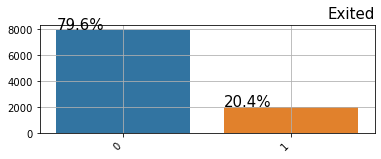

In [19]:
plot_cat_count_s(y)

Можно сказать, что имеется умеренная (moderate) несбалансированность классов.

### Анализ и обработка выбросов

In [20]:
def box_hist(data, col_name):
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data[col_name], ax=axs[0])
    sns.histplot(data=data[col_name], ax=axs[1])

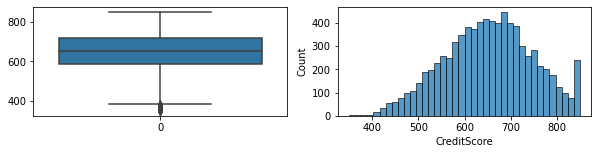

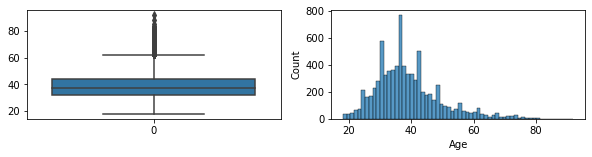

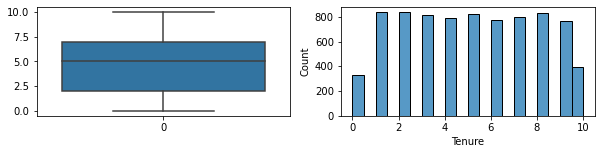

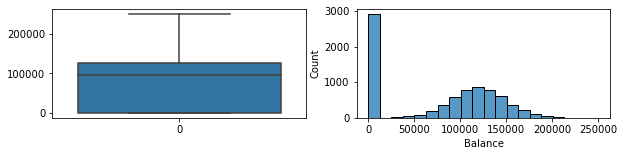

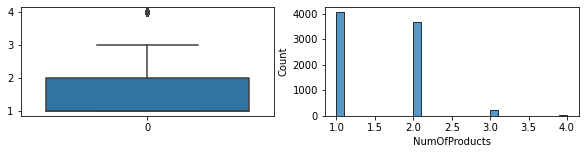

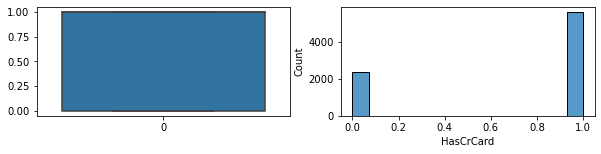

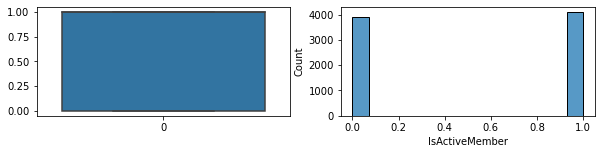

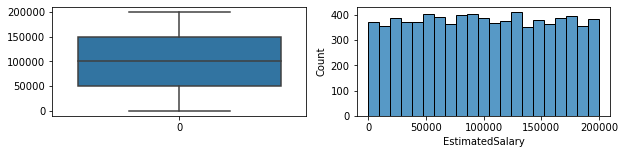

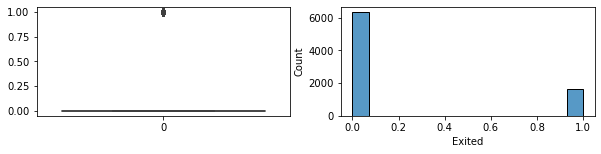

In [21]:
df_tmp = X_train.join(y_train).reset_index(drop=True)
for col_name in df.select_dtypes(include=np.number):
    box_hist(df_tmp, col_name)

X_train = df_tmp.loc[:, df_tmp.columns != target_column_name].copy()
y_train = df_tmp[target_column_name].copy()

### Pipeline

In [22]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [23]:
cat_columns = X.select_dtypes(include='category').columns.tolist()
bin_cat_columns = [col_name for col_name in X[cat_columns] if X[col_name].nunique() == 2]
mul_cat_columns = [col_name for col_name in cat_columns if col_name not in bin_cat_columns]
bool_columns = X.select_dtypes(include='bool').columns.tolist()
bin_columns = bin_cat_columns + bool_columns

num_columns = X.select_dtypes(include=np.number).columns.tolist()

str_columns = X.select_dtypes(include='string').columns.tolist()


print(f"cat_columns: {cat_columns}\nbin_cat_columns: {bin_cat_columns}\nmul_cat_columns: {mul_cat_columns}\nbool_columns: {bool_columns}\nbin_columns: {bin_columns}")
print(f"num_columns: {num_columns}")
print(f"str_columns: {str_columns}")

cat_columns: ['Gender']
bin_cat_columns: ['Gender']
mul_cat_columns: []
bool_columns: ['HasCrCard', 'IsActiveMember']
bin_columns: ['Gender', 'HasCrCard', 'IsActiveMember']
num_columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
str_columns: ['Surname', 'Geography']


In [24]:
bin_cat_transformer = Pipeline(steps=[
    ('encoder_ord', OrdinalEncoder())
])

In [25]:
mul_cat_transformer = Pipeline(steps=[
    ('astype_int', FunctionTransformer(lambda x: x.astype(int)))
])

In [26]:
num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_cat_transformer', bin_cat_transformer, bin_columns),
        ('mul_cat_transformer', mul_cat_transformer, mul_cat_columns),
        ('num_transformer', num_transformer, num_columns),
        ('drop', 'drop', str_columns),

])

In [28]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model_dtc', DecisionTreeClassifier(criterion="entropy"))
])

# pipeline.get_params()

In [29]:
X.drop(['Surname', 'Geography'], axis='columns')

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,
1,619,Female,42,2,0.00,1,True,True,101348.88
2,608,Female,41,1,83807.86,1,False,True,112542.58
3,502,Female,42,8,159660.80,3,True,False,113931.57
4,699,Female,39,1,0.00,2,False,False,93826.63
5,850,Female,43,2,125510.82,1,True,True,79084.10
...,...,...,...,...,...,...,...,...,...
9996,771,Male,39,5,0.00,2,True,False,96270.64
9997,516,Male,35,10,57369.61,1,True,True,101699.77
9998,709,Female,36,7,0.00,1,False,True,42085.58


In [31]:
X[bin_columns + mul_cat_columns + num_columns]

,Gender,HasCrCard,IsActiveMember,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
RowNumber,,,,,,,,,
1,Female,True,True,619,42,2,0.00,1,101348.88
2,Female,False,True,608,41,1,83807.86,1,112542.58
3,Female,True,False,502,42,8,159660.80,3,113931.57
4,Female,False,False,699,39,1,0.00,2,93826.63
5,Female,True,True,850,43,2,125510.82,1,79084.10
...,...,...,...,...,...,...,...,...,...
9996,Male,True,False,771,39,5,0.00,2,96270.64
9997,Male,True,True,516,35,10,57369.61,1,101699.77
9998,Female,False,True,709,36,7,0.00,1,42085.58


In [32]:
prep_for_test = preprocessor.fit(X_train, y_train)
pd.DataFrame(prep_for_test.transform(X_train))

,0,1,2,3,4,5,6,7,8
0,0.0,1.0,1.0,-0.240602,0.500000,0.0,-0.760560,0.0,-0.532875
1,0.0,1.0,0.0,0.000000,0.750000,0.0,-0.760560,1.0,-0.511327
2,0.0,0.0,0.0,1.195489,-1.083333,-0.8,-0.036758,0.0,-0.171935
3,1.0,0.0,0.0,0.060150,-0.916667,0.6,-0.760560,1.0,0.977899
4,1.0,0.0,0.0,-1.187970,-0.583333,1.0,0.255020,0.0,0.733761
...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,1.0,1.278195,1.333333,-0.2,0.217443,0.0,0.313913
7996,1.0,1.0,0.0,-0.774436,1.166667,0.0,-0.760560,1.0,0.543193
7997,1.0,0.0,0.0,0.142857,0.833333,-0.8,-0.760560,0.0,-0.087665
7998,1.0,0.0,1.0,1.315789,-0.500000,0.8,-0.760560,0.0,0.647825


In [33]:
# Параметры конвейеров могут быть заданы с использованием имен параметров, разделенных __
param_grid = {
    'model_dtc__max_depth': list(range(1, 15))
}
model_gcv = GridSearchCV(pipeline, param_grid, n_jobs=-1)
model_gcv.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_gcv.best_score_)
print(model_gcv.best_params_)

Best parameter (CV score=0.850):
{'model_dtc__max_depth': 5}


In [34]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('./tmp/pipeline.html', 'w') as f:
    f.write(estimator_html_repr(model_gcv.best_estimator_))

# the best estimator from grid search
model_gcv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bin_cat_transformer',
                                                  Pipeline(steps=[('encoder_ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('mul_cat_transformer',
                                                  Pipeline(steps=[('astype_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f3cff56b0d0>))]),
                                                  []),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('drop', 'drop',
                                                  ['Surname', 'Geography'])])),
                ('model_dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])

### Оценка качества модели (Evaluation)

In [35]:
y_predicted = model_gcv.predict(X_test)

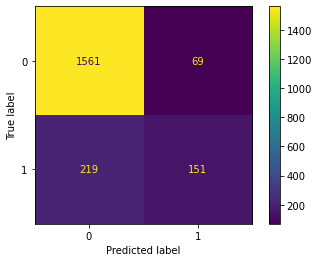

In [36]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_gcv, X_test, y_test)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1630
           1       0.69      0.41      0.51       370

    accuracy                           0.86      2000
   macro avg       0.78      0.68      0.71      2000
weighted avg       0.84      0.86      0.84      2000



In [38]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predicted, average='weighted') 

0.8408620706794573

In [39]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(y_test, y_predicted))

Accuracy:  0.856


### Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_gcv.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.855  0.835  0.8425 0.8575 0.8375]
0.85 accuracy with a standard deviation of 0.01
